# E-M

In [1]:
import numpy as np
import scipy.stats

In [2]:
# The number of clusters
k = 2

data = np.array([
    [0.2, 0.5],
    [0.4, 0.1],
    [0.3, 0.3],
    [1.0, 1.2],
    [1.3, 1.1],
    [1.4, 1.0]
])

mu = np.array([
    [1.1, 1.1],
    [1.3, 0.8]
])

cov = np.array([
    np.identity(2),
    np.identity(2)
])

pi = np.array([
    0.5, 0.5
])

init_parameters = {
    "mu" : mu,
    "cov": cov,
    "pi" : pi,
    "w"  : None
}
parameters = init_parameters

In [3]:
N = scipy.stats.multivariate_normal.pdf

In [4]:
def compute_responsibility(data, parameters):
    """
    Returns an (n, k) array where entry (i, j) is the responsibility of the jth
    Gaussian for the ith data point.
    """
    
    mixed_gaussian_probs = np.array([
        parameters["pi"][j] * N(data, parameters["mu"][j], parameters["cov"][j])
        for j in range(k)
    ])
    
    responsibility = mixed_gaussian_probs / sum(mixed_gaussian_probs)
    
    return responsibility.T

def update_mu(data, responsibility):
    """
    Returns a (k, d) array where entry (j,) is the updated mean for the jth
    cluster.
    """
    
    x = data
    w = responsibility
    
    # Note that w.T @ x is
    # (k, n) @ (n, d) -> (k, d)
    # gives us k rows, each one being the sum of w_ij * xi over i for class k
    # Equivalent to sum{i=1..n} w_ij xi
    return (w.T @ x) / w.sum(axis=0)[:, np.newaxis]

def update_cov(data, responsibility, mu):
    """
    Returns a (k, d, d) array where entry (j,) is the updated covariance for
    the jth cluster.
    """
    
    x = data
    w = responsibility
    
    # Equivalent to sum{i=1..n} w_ij
    wsums = w.sum(axis=0)
    
    return np.array([
        np.sum([
            # Equivalent to w_ij * (xi - mu_j)(xi - mu_j)^T
            w[i,j] * (x[i] - mu[j]).reshape(-1,1) @ (x[i] - mu[j]).reshape(1,-1)
            for i in range(len(data))
            # The resulting dimension is (n, d, d) so we should sum along axis 0
        ], axis=0)
        # And we divide each one by the sum of w_ij
        / wsums[j]
        for j in range(k)
    ])

def update_pi(responsibility):
    """
    Returns a (k,) array 
    """
    
    w = responsibility
    
    return w.mean(axis=0)

def update_parameters(data, responsibility):
    """Update all of the parameters in one shot."""
    new_mu = update_mu(data, responsibility)
    new_cov = update_cov(data, responsibility, new_mu)
    new_pi = update_pi(responsibility)
    return {
        "mu" : new_mu,
        "cov": new_cov,
        "pi" : new_pi,
        "w"  : responsibility
    }

def em_iteration(data, initial_parameters):
    """Run an iteration of E-M."""
    responsibility = compute_responsibility(data, initial_parameters)
    return update_parameters(data, responsibility)

In [5]:
import pandas as pd

def parameter_row(parameters):
    
    r = 3
    
    if type(parameters) == dict:
        return pd.DataFrame({
            "mu0" : [parameters["mu"][0].round(r)],
            "mu1" : [parameters["mu"][1].round(r)],
            "cov0": [parameters["cov"][0].round(r)],
            "cov1": [parameters["cov"][1].round(r)],
            "pi0" : [parameters["pi"][0].round(r)],
            "pi1" : [parameters["pi"][1].round(r)],
            "w0"  : [parameters["w"][:,0].round(r)] if np.any(parameters["w"]) else None,
            "w1"  : [parameters["w"][:,1].round(r)] if np.any(parameters["w"]) else None,
        })
    else:
        return pd.DataFrame({
            "mu0" : [parameters.means_[0].round(r)],
            "mu1" : [parameters.means_[1].round(r)],
            "cov0": [parameters.covariances_[0].round(r)],
            "cov1": [parameters.covariances_[1].round(r)],
            "pi0" : [parameters.weights_[0].round(r)],
            "pi1" : [parameters.weights_[1].round(r)],
            "w0"  : [parameters.predict_proba(data)[:,0].round(r)],
            "w1"  : [parameters.predict_proba(data)[:,1].round(r)],
        })

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_gaussians(parameters):
    
    # Source for ellipses code:
    # https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py


    colors = ['dodgerblue', 'darkorange']

    def make_ellipses(parameters, ax):
        for n, color in enumerate(colors):
            
            if type(parameters) == dict:
                covariances = parameters["cov"][n]
            else:
                covariances = parameters.covariances_[n]

            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            
            if type(parameters) == dict:
                ell = mpl.patches.Ellipse(parameters["mu"][n], v[0], v[1],
                                          180 + angle, color=color)
            else:
                ell = mpl.patches.Ellipse(parameters.means_[n], v[0], v[1],
                                          180 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)
            ax.set_aspect('equal', 'datalim')


    ax = plt.axes()

    # Draw our data
    ax.scatter(data[:, 0], data[:, 1], c='k')

    # Draw our Guassians
    make_ellipses(parameters, ax)

    # Make the plot big enough to view everything
    plt.xlim(-2, 4)
    plt.ylim(-2, 4)

    plt.show()

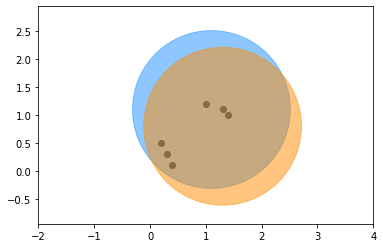

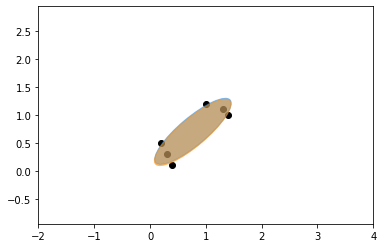

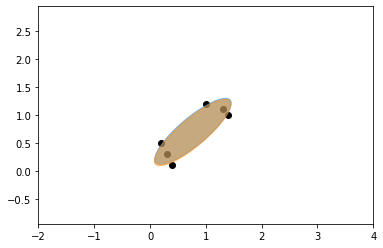

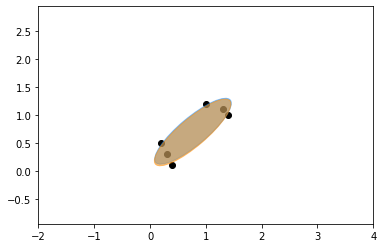

In [7]:
parameters = init_parameters
df = parameter_row(parameters)

plot_gaussians(parameters)

for i in range(3):
    parameters = em_iteration(data, parameters)
    df = df.append(parameter_row(parameters))
    plot_gaussians(parameters)
    
em_result = df.reset_index(drop=True)

In [8]:
# Looks like we got caught in a local minimum! :sad:

In [9]:
# Display the table with line-breaks in matrices for better readability.
from IPython.display import HTML
style = """
<style>
    table.dataframe {
        white-space: pre;
        font-family: Consolas, monospace;
    }
    table.dataframe * {
        border: 1px solid #ccc;
    }
</style>
"""
html_out = (
    em_result.applymap(str).T
    .to_html().replace("\\n", "<br>").replace("\n", '')
)

display(HTML(style + html_out))

,0,1,2,3
mu0,[1.1 1.1],[0.769 0.709],[0.769 0.71 ],[0.77 0.71]
mu1,[1.3 0.8],[0.764 0.691],[0.764 0.69 ],[0.764 0.69 ]
cov0,[[1. 0.] [0. 1.]],[[0.235 0.172] [0.172 0.175]],[[0.235 0.172] [0.172 0.175]],[[0.236 0.172] [0.172 0.174]]
cov1,[[1. 0.] [0. 1.]],[[0.236 0.175] [0.175 0.178]],[[0.236 0.175] [0.175 0.178]],[[0.235 0.175] [0.175 0.179]]
pi0,0.5,0.503,0.503,0.503
pi1,0.5,0.497,0.497,0.497
w0,None,[0.516 0.476 0.496 0.529 0.506 0.494],[0.52 0.473 0.495 0.527 0.506 0.496],[0.522 0.47 0.495 0.527 0.506 0.498]
w1,None,[0.484 0.524 0.504 0.471 0.494 0.506],[0.48 0.527 0.505 0.473 0.494 0.504],[0.478 0.53 0.505 0.473 0.494 0.502]


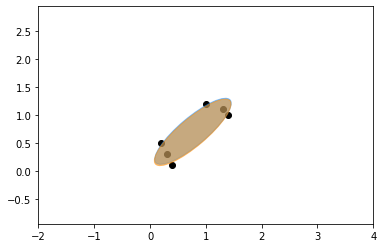

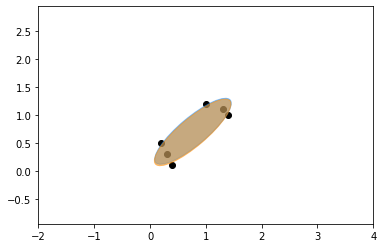

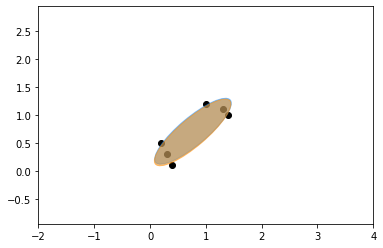

In [10]:
# We can double check our algorithm with sklearn.
#
# Though, don't be surprised if some numbers are slightly different!

import sklearn.mixture

parameters = init_parameters

gmm = sklearn.mixture.GaussianMixture(
    n_components=k,
    weights_init=parameters["pi"],
    means_init=parameters["mu"],
    precisions_init=parameters["cov"], # Precision is actually the inverse of the
    max_iter=1,                     # covariance, but we're using Identities
    warm_start=True                 # so we don't need to change anything.
)

df = parameter_row(parameters)

for i in range(3):
    gmm.fit(data)
    df = df.append(parameter_row(gmm))
    plot_gaussians(gmm)
    
sk_result = df.reset_index(drop=True)

In [11]:
sk_result.T

,0,1,2,3
mu0,"[1.1, 1.1]","[0.769, 0.709]","[0.769, 0.71]","[0.77, 0.71]"
mu1,"[1.3, 0.8]","[0.764, 0.691]","[0.764, 0.69]","[0.764, 0.69]"
cov0,"[[1.0, 0.0], [0.0, 1.0]]","[[0.235, 0.172], [0.172, 0.175]]","[[0.235, 0.172], [0.172, 0.175]]","[[0.236, 0.172], [0.172, 0.174]]"
cov1,"[[1.0, 0.0], [0.0, 1.0]]","[[0.236, 0.175], [0.175, 0.178]]","[[0.236, 0.175], [0.175, 0.178]]","[[0.235, 0.175], [0.175, 0.179]]"
pi0,0.5,0.503,0.503,0.503
pi1,0.5,0.497,0.497,0.497
w0,None,"[0.52, 0.473, 0.495, 0.527, 0.506, 0.496]","[0.522, 0.47, 0.495, 0.527, 0.506, 0.498]","[0.525, 0.465, 0.494, 0.526, 0.507, 0.5]"
w1,None,"[0.48, 0.527, 0.505, 0.473, 0.494, 0.504]","[0.478, 0.53, 0.505, 0.473, 0.494, 0.502]","[0.475, 0.535, 0.506, 0.474, 0.493, 0.5]"


In [12]:
em_result.T

,0,1,2,3
mu0,"[1.1, 1.1]","[0.769, 0.709]","[0.769, 0.71]","[0.77, 0.71]"
mu1,"[1.3, 0.8]","[0.764, 0.691]","[0.764, 0.69]","[0.764, 0.69]"
cov0,"[[1.0, 0.0], [0.0, 1.0]]","[[0.235, 0.172], [0.172, 0.175]]","[[0.235, 0.172], [0.172, 0.175]]","[[0.236, 0.172], [0.172, 0.174]]"
cov1,"[[1.0, 0.0], [0.0, 1.0]]","[[0.236, 0.175], [0.175, 0.178]]","[[0.236, 0.175], [0.175, 0.178]]","[[0.235, 0.175], [0.175, 0.179]]"
pi0,0.5,0.503,0.503,0.503
pi1,0.5,0.497,0.497,0.497
w0,None,"[0.516, 0.476, 0.496, 0.529, 0.506, 0.494]","[0.52, 0.473, 0.495, 0.527, 0.506, 0.496]","[0.522, 0.47, 0.495, 0.527, 0.506, 0.498]"
w1,None,"[0.484, 0.524, 0.504, 0.471, 0.494, 0.506]","[0.48, 0.527, 0.505, 0.473, 0.494, 0.504]","[0.478, 0.53, 0.505, 0.473, 0.494, 0.502]"


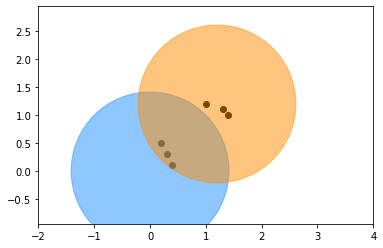

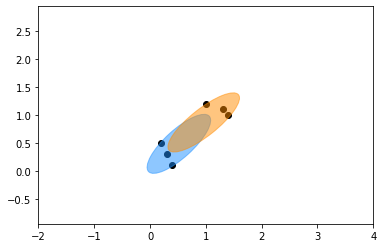

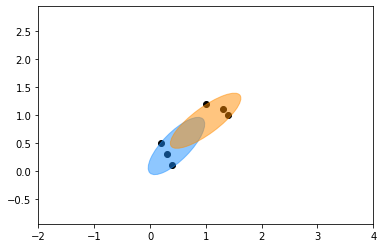

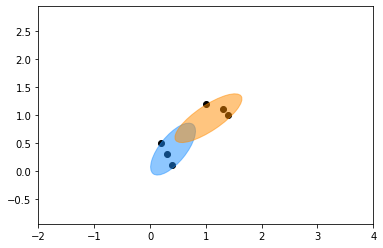

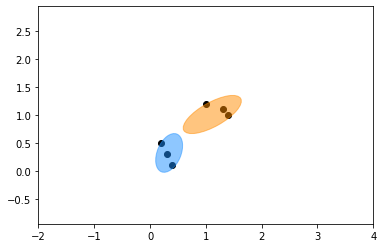

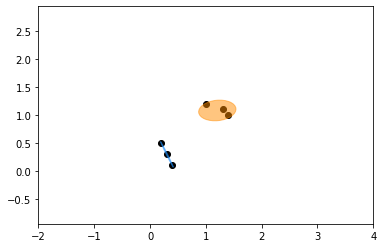

In [13]:
# That was a little disappointing.
# Let's try a different starting point and boost the number of iterations to see
# if we can get the clusters we want!

mu_new = np.array([
    [0, 0],
    [1.2, 1.2]
])

parameters = {**init_parameters, "mu": mu_new}

plot_gaussians(parameters)

for i in range(5):
    parameters = em_iteration(data, parameters)
    plot_gaussians(parameters)

In [14]:
# Wow, that last step was dramatic.
#
# Demonstrates that E-M converges quickly once initial separation takes place.